# 动量因子

In [10]:
import tushare as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime, timedelta
from scipy.stats import zscore
from scipy.signal import butter, filtfilt

In [11]:
# 读取数据, index_col=0表示第一列为索引，parse_dates=True表示将第一列解析为日期格式
data = pd.read_csv('hs300_stock_data.csv', index_col=0, parse_dates=True)
start_date = '2014-12-01'
data = data[data.index >= start_date]
data.head()

,600519.SH,300750.SZ,601318.SH,600036.SH,000333.SZ,600900.SH,002594.SZ,601166.SH,300059.SZ,600030.SH,...,688187.SH,603833.SH,601136.SH,601236.SH,300979.SZ,688082.SH,601808.SH,000800.SZ,600377.SH,001289.SZ
trade_date,,,,,,,,,,,,,,,,,,,,,
2014-12-01,160.06,NaN,50.75,12.11,23.35,8.90,43.40,11.92,25.50,17.52,...,NaN,NaN,NaN,NaN,NaN,NaN,17.48,12.33,6.56,NaN
2014-12-02,161.14,NaN,54.29,12.70,24.53,8.99,43.52,12.59,25.88,18.80,...,NaN,NaN,NaN,NaN,NaN,NaN,17.80,12.44,6.60,NaN
2014-12-03,164.83,NaN,55.01,12.65,25.20,9.10,43.15,12.38,27.09,19.15,...,NaN,NaN,NaN,NaN,NaN,NaN,18.11,13.04,6.64,NaN
2014-12-04,174.13,NaN,59.99,13.64,25.65,9.28,44.58,13.29,29.80,21.07,...,NaN,NaN,NaN,NaN,NaN,NaN,19.64,13.18,6.75,NaN
2014-12-05,170.92,NaN,59.13,13.95,24.70,9.24,43.36,13.60,31.27,23.18,...,NaN,NaN,NaN,NaN,NaN,NaN,18.97,13.74,6.63,NaN


In [12]:
def get_period_date_ranges(period_months):
    # 生成每年指定时间周期的对应日期范围
    result = []
    
    # 获取数据的起止日期
    data_start_date = data.index.min()
    data_end_date = data.index.max()  # 添加这行来定义 data_end_date
    # print(f"数据范围: {data_start_date} 到 {data_end_date}")  # 添加打印检查 
    
    # 获取初始日期范围
    initial_start_date = data.loc['2014-12'].index.strftime('%Y-%m-%d')[0]
    initial_end_date = data.loc['2014-12'].index.strftime('%Y-%m-%d')[-1]
    # 存储日期范围的元组（tuple）
    result.append((initial_start_date, initial_end_date))
       # 根据实际数据范围生成年份列表
    start_year = data_start_date.year
    end_year = data_end_date.year
    
    # 生成后续日期范围
    for year in range(start_year + 1, end_year + 1):  # 从数据开始年份到结束年份
        for month_pair in period_months:
            start_month, end_month = month_pair[0], month_pair[1]
            Q_start_mon = f"{year}-{start_month:02d}"
            Q_end_mon = f"{year}-{end_month:02d}"
            
            try:
                # 检查该月份是否有数据
                if Q_start_mon not in data.index.strftime('%Y-%m'):
                    continue
                    
                Q_start_date = data.loc[Q_start_mon].index.strftime('%Y-%m-%d')[0]
                Q_end_date = data.loc[Q_end_mon].index.strftime('%Y-%m-%d')[-1]
                
                # 确保日期在数据范围内
                if pd.Timestamp(Q_end_date) <= data_end_date:
                    result.append((Q_start_date, Q_end_date))
            except KeyError:
                continue

    # 确保所有日期是 pd.Timestamp 格式
    result = [(pd.Timestamp(start), pd.Timestamp(end)) for start, end in result]
    return result

In [13]:
def get_date_ranges(mode):
    d = {
        'Quarter': get_period_date_ranges([(1, 3), (4, 6), (7, 9), (10, 12)]),
        'Two months': get_period_date_ranges([(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12)]),
        'One month': get_period_date_ranges([(1,1),(2,2),(3,3),(4,4),(5,5),(6,6),
                                              (7,7),(8,8),(9,9),(10,10),(11,11),(12,12)])
    }
    return d[mode]


In [14]:
def batch_low_pass_filter(df, cutoff=0.1):
    """
    对整个数据框进行批量低通滤波，去除高频部分。
    参数：- df: 数据框，每列是一只股票的时间序列数据。
    - cutoff: 截止频率，值越小保留的低频越少。
    返回：
    - 滤波后的数据框
    """
    # 确保数据是 numpy array
    data = df.to_numpy()
    
    # 执行傅立叶变换 (批量处理)
    fft_result = np.fft.fft(data, axis=0)
    frequencies = np.fft.fftfreq(data.shape[0])  # 计算频率
    
    # 构建滤波器
    filter_mask = np.abs(frequencies) <= cutoff
    fft_result[~filter_mask, :] = 0  # 应用滤波器
    
    # 逆傅立叶变换并保留实部
    filtered_data = np.fft.ifft(fft_result, axis=0).real
    
    return pd.DataFrame(filtered_data, index=df.index, columns=df.columns)


def batch_butterworth_low_pass_filter(df, cutoff=0.1, fs=1.0, order=4):
    """
    对整个数据框进行批量 Butterworth 低通滤波，去除高频部分。

    参数：
    - df: 数据框，每列是一只股票的时间序列数据。
    - cutoff: 截止频率，值越大保留的低频越多（单位：Hz）。
    - fs: 采样频率（单位：Hz），通常为 1.0。
    - order: Butterworth 滤波器的阶数，默认为 4。

    返回：
    - 滤波后的数据框
    """
    # 计算滤波器的系数
    nyquist = 0.5 * fs  # 奈奎斯特频率
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    # 对每列数据进行滤波
    filtered_data = df.apply(lambda col: filtfilt(b, a, col), axis=0)

    return pd.DataFrame(filtered_data, index=df.index, columns=df.columns)

# fs = 1 表示采样频率为1Hz
filtered_df = batch_butterworth_low_pass_filter(data, cutoff=0.1, fs=1.0, order=4)

In [19]:
# 捕捉价格趋势（动量）、 控制风险（波动率）、通过低通滤波减少市场噪声的影响
def calculate_momentum(prev_day, lookback=6, cutoff=0.1):
    ten_years_ago = prev_day - pd.DateOffset(years=10)
    
    filtered_data = batch_low_pass_filter(data[ ten_years_ago  : prev_day], cutoff)
    prev_day_idx = filtered_data.index.get_loc(prev_day)
    old_day_idx = prev_day_idx - lookback
    
    return filtered_data.iloc[prev_day_idx] / filtered_data.iloc[old_day_idx]

def calculate_volatility(prev_day, lookback=6, cutoff=0.1):
    ten_years_ago = prev_day - pd.DateOffset(years=10)

    filtered_data = batch_low_pass_filter(data[ ten_years_ago  : prev_day], cutoff)
    prev_day_idx = filtered_data.index.get_loc(prev_day)
    old_day_idx = prev_day_idx - lookback*21
    
    return filtered_data[old_day_idx : prev_day_idx+1].std()

# 计算 RSI
def calculate_rsi(prev_day, lookback=6, cutoff=0.1):
    ten_years_ago = prev_day - pd.DateOffset(years=10)

    filtered_data = batch_low_pass_filter(data[ ten_years_ago  : prev_day], cutoff)
    prev_day_idx = filtered_data.index.get_loc(prev_day)
    old_day_idx = prev_day_idx - lookback
    
    delta = filtered_data[old_day_idx : prev_day_idx+1].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=lookback).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=lookback).mean()
    # 避免除零错误
    loss = loss.replace(0, 1e-10)
    
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi.iloc[-1]



In [20]:

"""
def STOP_LOSS_OR_TAKE_PROFIT(weighted_portfolio):
    for stock in weighted_portfolio.columns:    
        stop_loss_or_take_profit = 'long'
        temp_return = 1
        change_status = False
        factor = 1
        
        for date in portfolio.index:

            if change_status:
                temp_return = 1
                change_status = False

            
            weighted_portfolio.loc[date, stock] *= factor
            temp_return*= (1+weighted_portfolio.loc[date, stock])

            
            if temp_return<=(1-0.02) and stop_loss_or_take_profit == 'long':
                stop_loss_or_take_profit = 'short'
                change_status = True
                factor*=-1
                continue
            if temp_return<=(1-0.02) and stop_loss_or_take_profit == 'short':
                stop_loss_or_take_profit = 'long'
                change_status = True
                factor*=-1
                
    return weighted_portfolio"""


def STOP_LOSS_OR_TAKE_PROFIT(weighted_portfolio):
    for stock in weighted_portfolio.columns:    
        stop_loss_or_take_profit = False
        temp_return = 1
        stock_portfolio = weighted_portfolio[stock]
        for date in portfolio.index:
            if stop_loss_or_take_profit:
                weighted_portfolio[stock][date] = 0
            temp_return*= (1+stock_portfolio[date])
            C1 = temp_return>=(1+0.20)
            C2 = temp_return<=(1-0.05)
            #if C1 or C2:
            if C2:
                stop_loss_or_take_profit = True
    return weighted_portfolio


In [24]:
# 初始资本和日期
initial_capital = 100
#date_ranges = get_date_ranges(mode='Quarter')
date_ranges = get_date_ranges(mode='Two months')
#date_ranges = get_date_ranges(mode='One month')
data_index = data.index

# 初始化
df_list = []

# 策略——多因子选股，动态权重，月度调仓
# 回測策略
for idx in range(1, len(date_ranges)):

    date_range = date_ranges[idx]
    prev_date_range = date_ranges[idx - 1]
    
    start_date, end_date = date_range[0], date_range[1]
    previous_day = prev_date_range[-1]

    # 计算因子
    cutoff = 0.05
    rsi_factor = calculate_rsi(previous_day, lookback=14,  cutoff=cutoff)
    rsi_factor = rsi_factor.dropna()
    # 计算波动率因子
    volatility = calculate_volatility(previous_day).dropna()
    common_index = rsi_factor.index.intersection(volatility.index)    
    
    rsi_factor = rsi_factor[common_index]
    volatility = volatility[common_index]
    # 计算综合得分（动量越大越好，波动率越小越好）
    scores = zscore(rsi_factor) -zscore(volatility)
    scores = pd.Series(scores, index=volatility.index)  # 将 scores 转换为 pandas.Series
    only_long = True
    
    if only_long:
        selected_stocks = scores.nlargest(10).index
        selected_scores = scores[selected_stocks]
        portfolio = data[selected_stocks].pct_change(fill_method=None)
        portfolio = portfolio[start_date:end_date]
        #print(date_range, selected_scores)

    else:
        # 做多和做空的股票
        long_stocks  = scores.nsmallest(10).index  # 排名前 30 的股票做多
        short_stocks = scores.nlargest(5).index  # 排名后 30 的股票做空
        
        # 投资组合
        long_portfolio =   data[ start_date-pd.DateOffset(days=5) : end_date ][long_stocks ].pct_change()  # 做多組合的每日回報率
        short_portfolio = -data[ start_date-pd.DateOffset(days=5) : end_date ][short_stocks].pct_change()  # 做空組合的每日回報率（乘以 -1 表示做空）
        #long_portfolio =   data[long_stocks ].pct_change()  # 做多組合的每日回報率
        #short_portfolio = -data[short_stocks].pct_change()  # 做空組合的每日回報率（乘以 -1 表示做空）
        
        portfolio = pd.concat([long_portfolio, short_portfolio], axis=1)

    # 止损止盈
    portfolio = STOP_LOSS_OR_TAKE_PROFIT(portfolio.copy())
    weights = np.exp(selected_scores) / np.sum(np.exp(selected_scores))
    #print(weights.values)
    #weights = pd.Series(1 / len(selected_scores), index=selected_scores.index)
    weighted_portfolio = portfolio.mul(weights, axis=1)
            
    # 回报率和累计汇报率
    weighted_returns = weighted_portfolio.sum(axis=1)[start_date:end_date]

    cumulative_returns = (1 + weighted_returns).cumprod() * initial_capital
    df_list.append(cumulative_returns)

    # 更新初始資本
    initial_capital = cumulative_returns.iloc[-1]
    

# 合并累计回报
strategy_result = pd.concat(df_list, axis=0)
# print(strategy_result)


In [25]:
# 大盘数据（HS300 Index）
index_ticker = '000300.SS'
M_start_date = date_ranges[0][0]
M_end_date = pd.to_datetime(date_ranges[-1][1]) + timedelta(days=1)
index_data = pd.read_csv('hs300_index_data.csv', index_col=0, parse_dates=True)
index_data = index_data[(index_data.index >= M_start_date) & (index_data.index <= M_end_date)]
print(index_data.head())
# 大盘累计回报
index_returns = index_data['close'].pct_change().loc[strategy_result.index]
cumulative_index_returns = (1 + index_returns).cumprod() * 100

               close
trade_date          
2014-12-01  2819.812
2014-12-02  2923.940
2014-12-03  2967.549
2014-12-04  3104.351
2014-12-05  3124.885


In [26]:
# 绩效指标
def calculate_sharpe_ratio(returns, risk_free_rate=0.05, annualization_factor=252):
    excess_returns = returns - risk_free_rate / annualization_factor
    return excess_returns.mean() / returns.std() * np.sqrt(annualization_factor)

def calculate_max_drawdown(cumulative_returns):
    cumulative_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / cumulative_max - 1
    return drawdown.min()

def calculate_annualized_return(cumulative_returns):
    total_return = cumulative_returns.iloc[-1] / cumulative_returns.iloc[0] - 1
    cumulative_returns.index = pd.to_datetime(cumulative_returns.index)
    num_years = (cumulative_returns.index[-1] - cumulative_returns.index[0]).days / 365.25
    
    
    return (1 + total_return) ** (1 / num_years) - 1

def calculate_cumulative_return(cumulative_returns):
    return cumulative_returns.iloc[-1] / cumulative_returns.iloc[0] - 1

def calculate_turnover(data, selected_stocks):
    selected_data = data[selected_stocks]
    trades = selected_data.pct_change().dropna().abs().sum(axis=1)
    avg_portfolio_value = selected_data.mean().mean()
    turnover = trades.mean() / avg_portfolio_value
    return turnover

def calculate_sortino_ratio(strategy_result, risk_free_rate=0.05, periods_per_year=252):
    # 日收益率
    daily_returns = strategy_result.pct_change().dropna()
    
    # 每日风险免费利率
    daily_risk_free_rate = risk_free_rate / periods_per_year
    
    # 超额回报率 (Excess Return)
    excess_returns = daily_returns - daily_risk_free_rate
    
    # 下行偏差 (Downside Deviation)
    downside_returns = excess_returns[excess_returns < 0]
    downside_deviation = np.sqrt(np.mean(downside_returns ** 2))
    
    # Sortino Ratio
    sortino_ratio = excess_returns.mean() / downside_deviation
    return sortino_ratio


def show_bt_result(result, title):
    returns = result.pct_change().dropna()
    sharpe_ratio = calculate_sharpe_ratio(returns)
    max_drawdown = calculate_max_drawdown(result)
    annualized_return = calculate_annualized_return(result)
    cumulative_return = calculate_cumulative_return(result)
    sortino_ratio = calculate_sortino_ratio(result)
    print(title)
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")
    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Cumulative Return: {cumulative_return:.2%}")
    print(f"Sortino Ratio: {sortino_ratio:.4f}")
    print()


first_hf_pd  = '2023-12-31'
second_hf_pd = '2024-01-01'

show_bt_result(strategy_result[ : first_hf_pd], "策略测试期:2015-2024")
show_bt_result(cumulative_index_returns[ : first_hf_pd], '大盘测试期:2015-2024')

show_bt_result(strategy_result[second_hf_pd : ], "策略验证期:2024-2025")
show_bt_result(cumulative_index_returns[second_hf_pd : ], "大盘验证期:2024-2025")


策略测试期:2015-2024
Sharpe Ratio: 0.32
Maximum Drawdown: -22.52%
Annualized Return: 9.05%
Cumulative Return: 117.75%
Sortino Ratio: 0.0213

大盘测试期:2015-2024
Sharpe Ratio: -0.14
Maximum Drawdown: -46.70%
Annualized Return: -0.66%
Cumulative Return: -5.78%
Sortino Ratio: -0.0085

策略验证期:2024-2025
Sharpe Ratio: 0.23
Maximum Drawdown: -13.98%
Annualized Return: 7.32%
Cumulative Return: 9.81%
Sortino Ratio: 0.0161

大盘验证期:2024-2025
Sharpe Ratio: 0.27
Maximum Drawdown: -15.66%
Annualized Return: 8.45%
Cumulative Return: 11.35%
Sortino Ratio: 0.0187



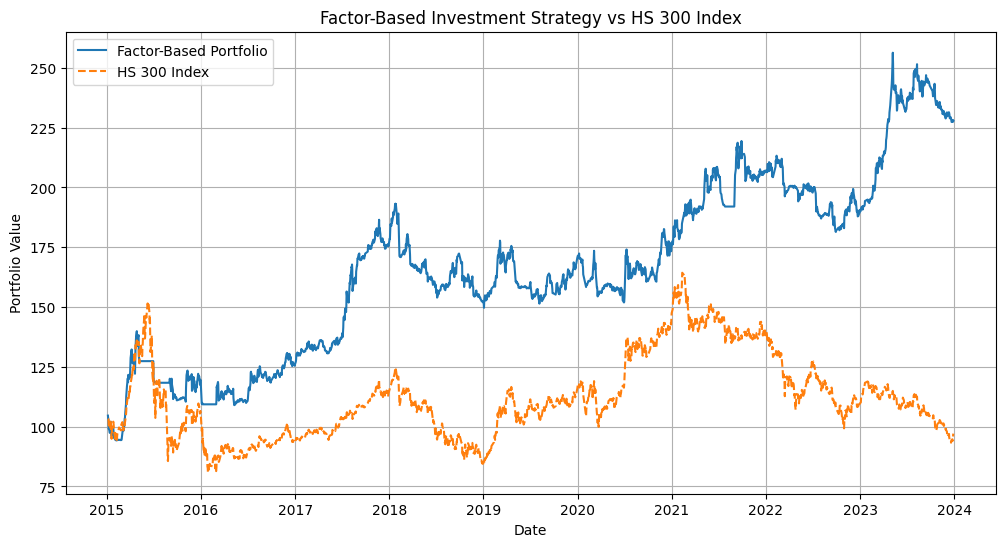

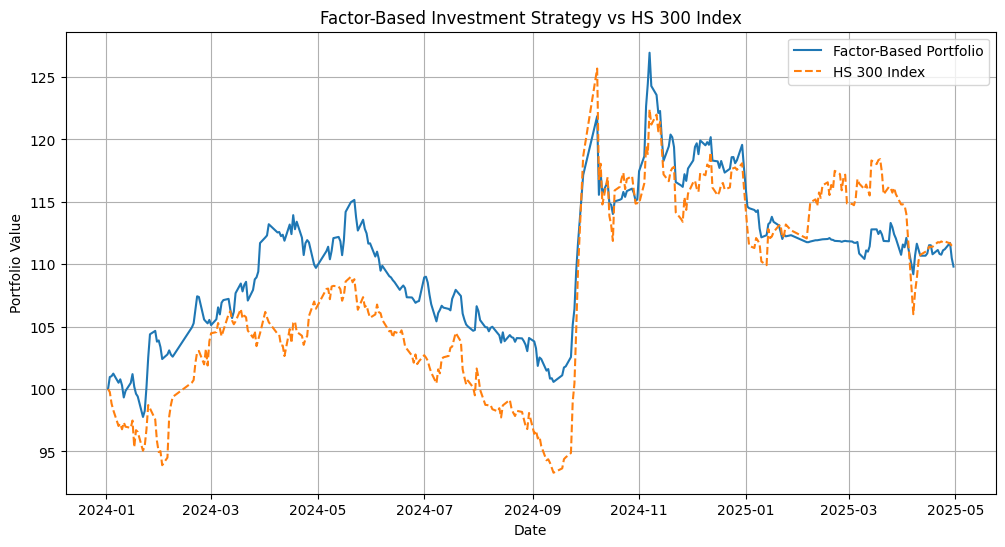

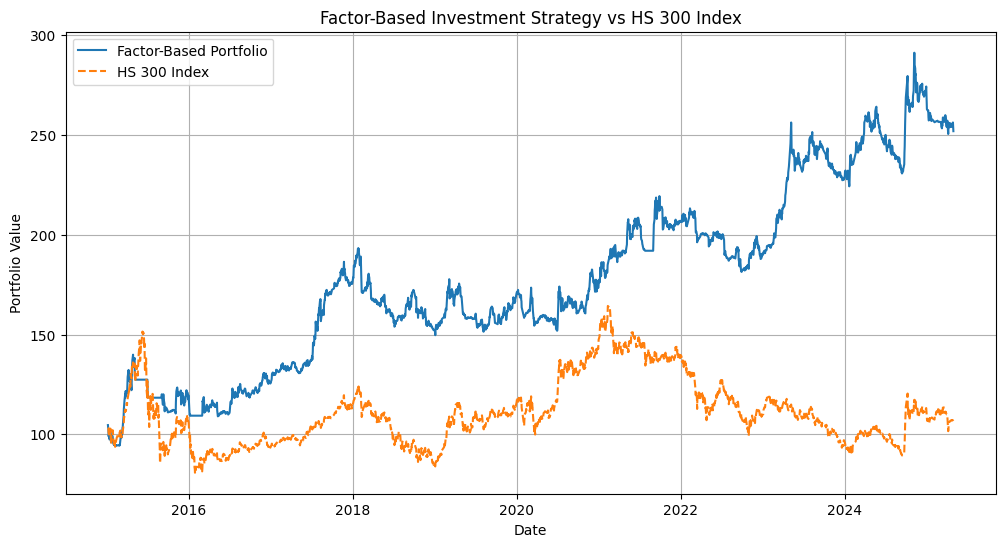

In [27]:
def Plot_result(Strategy_result, Cumulative_index_returns):
    plt.figure(figsize=(12, 6))
    plt.plot(Strategy_result, label='Factor-Based Portfolio')
    plt.plot(Cumulative_index_returns, label='HS 300 Index', linestyle='--')
    plt.title('Factor-Based Investment Strategy vs HS 300 Index')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid()
    plt.show()
    
Plot_result(strategy_result[ : first_hf_pd], cumulative_index_returns[ : first_hf_pd])
Plot_result(strategy_result[second_hf_pd : ] / strategy_result[second_hf_pd : ].iloc[0]*100, 
            cumulative_index_returns[second_hf_pd : ] / cumulative_index_returns[second_hf_pd : ].iloc[0]*100)
Plot_result(strategy_result, cumulative_index_returns)


In [28]:
# 初始资本和日期
initial_capital = 100
#date_ranges = get_date_ranges(mode='Quarter')
date_ranges = get_date_ranges(mode='Two months')
#date_ranges = get_date_ranges(mode='One month')
data_index = data.index

# 初始化
df_list = []

# 策略——多因子选股，动态权重，月度调仓
# 回測策略
for idx in range(1, len(date_ranges)):

    date_range = date_ranges[idx]
    prev_date_range = date_ranges[idx - 1]
    
    start_date, end_date = date_range[0], date_range[1]
    previous_day = prev_date_range[-1]

    # 计算因子
    cutoff = 0.05
    """
    m1 = (calculate_momentum(previous_day, lookback=5,  cutoff=cutoff)*
          calculate_momentum(previous_day, lookback=6,  cutoff=cutoff)*
          calculate_momentum(previous_day, lookback=7,  cutoff=cutoff))**(1/3)

    
    m2 = (calculate_momentum(previous_day, lookback=14,  cutoff=cutoff)*
          calculate_momentum(previous_day, lookback=15,  cutoff=cutoff)*
          calculate_momentum(previous_day, lookback=16,  cutoff=cutoff))**(1/3)
    
    m3 = (calculate_momentum(previous_day, lookback=29,  cutoff=cutoff)*
          calculate_momentum(previous_day, lookback=30,  cutoff=cutoff)*
          calculate_momentum(previous_day, lookback=31,  cutoff=cutoff))**(1/3)
    
    m4 = (calculate_momentum(previous_day, lookback=59,  cutoff=cutoff)*
          calculate_momentum(previous_day, lookback=60,  cutoff=cutoff)*
          calculate_momentum(previous_day, lookback=61,  cutoff=cutoff))**(1/3)

    """
    m1 = calculate_momentum(previous_day, lookback=6,  cutoff=cutoff)
    m2 = calculate_momentum(previous_day, lookback=15,  cutoff=cutoff)
    m3 = calculate_momentum(previous_day, lookback=30,  cutoff=cutoff)
    #m4 = calculate_momentum(previous_day, lookback=60,  cutoff=cutoff)
    #m5 = calculate_momentum(previous_day, lookback=45,  cutoff=cutoff)
   
    # 合成最终动量因子（几何平均）
    momentum = (m1*m2*m3).dropna()

    # 计算波动率因子
    volatility = calculate_volatility(previous_day).dropna()
    # 计算市场市值因子
    market_cap_factor = calculate_market_cap_factor(market_cap_data)
    market_cap = market_cap_factor.dropna()
    common_index = momentum.index.intersection(volatility.index)
    common_index = common_index.intersection(market_cap.index)   
    momentum = momentum[common_index]
    volatility = volatility[common_index]
    market_cap = market_cap[common_index]
    # 计算综合得分（动量越大越好，波动率越小越好）
    scores = zscore(momentum) -zscore(volatility)-zscore(market_cap)
    
    only_long = True
    
    if only_long:
        selected_stocks = scores.nlargest(10).index
        selected_scores = scores[selected_stocks]
        portfolio = data[selected_stocks].pct_change(fill_method=None)
        portfolio = portfolio[start_date:end_date]
        #print(date_range, selected_scores)

    else:
        # 做多和做空的股票
        long_stocks  = scores.nsmallest(10).index  # 排名前 30 的股票做多
        short_stocks = scores.nlargest(5).index  # 排名后 30 的股票做空
        
        # 投资组合
        long_portfolio =   data[ start_date-pd.DateOffset(days=5) : end_date ][long_stocks ].pct_change()  # 做多組合的每日回報率
        short_portfolio = -data[ start_date-pd.DateOffset(days=5) : end_date ][short_stocks].pct_change()  # 做空組合的每日回報率（乘以 -1 表示做空）
        #long_portfolio =   data[long_stocks ].pct_change()  # 做多組合的每日回報率
        #short_portfolio = -data[short_stocks].pct_change()  # 做空組合的每日回報率（乘以 -1 表示做空）
        
        portfolio = pd.concat([long_portfolio, short_portfolio], axis=1)

    # 止损止盈
    portfolio = STOP_LOSS_OR_TAKE_PROFIT(portfolio.copy())
    weights = np.exp(selected_scores) / np.sum(np.exp(selected_scores))
    #print(weights.values)
    #weights = pd.Series(1 / len(selected_scores), index=selected_scores.index)
    weighted_portfolio = portfolio.mul(weights, axis=1)
            
    # 回报率和累计汇报率
    weighted_returns = weighted_portfolio.sum(axis=1)[start_date:end_date]
    if idx==121:
      print(weighted_returns)
    cumulative_returns = (1 + weighted_returns).cumprod() * initial_capital
    df_list.append(cumulative_returns)

    # 更新初始資本
    initial_capital = cumulative_returns.iloc[-1]
    

# 合并累计回报
strategy_result = pd.concat(df_list, axis=0)
# print(strategy_result)



NameError: name 'calculate_market_cap_factor' is not defined